In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold

In [ ]:
data = pd.read_csv('/content/labelled_train_set.csv')

In [ ]:
def type2(x):
  if x == 'AI-generated':
    return 1
  else:
    return 0

X = data['Article']
y = data['Type'].apply(type2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# BERT Classifier Model
class BERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
#By experimenting with Hyperparameter values these were found to be best
MAX_LEN = 160
BATCH_SIZE = 8
EPOCHS = 5

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size, num_workers=0):
    ds = TextDataset(
        texts=df.Article.to_numpy(),
        labels=df.Type.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=num_workers)

In [ ]:
#for training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#for evaluating the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#based on cuda availability
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()


In [ ]:
skf = StratifiedKFold(n_splits=5)
accuracies = []
f1_scores = []
precisions = []
recalls = []

In [ ]:
for train_index, test_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    train_data_loader = create_data_loader(pd.DataFrame({'Article': X_train, 'Type': y_train}), tokenizer, MAX_LEN, BATCH_SIZE, num_workers=0)
    val_data_loader = create_data_loader(pd.DataFrame({'Article': X_val, 'Type': y_val}), tokenizer, MAX_LEN, BATCH_SIZE, num_workers=0)

    model = BERTClassifier(len(set(y)))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=total_steps // 2, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_data_loader.dataset))
        print(f'Train loss {train_loss} accuracy {train_acc}')
        val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(val_data_loader.dataset))
        print(f'Val   loss {val_loss} accuracy {val_acc}')

    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for d in val_data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            val_predictions.extend(preds)
            val_labels.extend(labels)

    val_predictions = torch.stack(val_predictions).cpu()
    val_labels = torch.stack(val_labels).cpu()

    accuracies.append(accuracy_score(val_labels, val_predictions))
    f1_scores.append(f1_score(val_labels, val_predictions))
    precisions.append(precision_score(val_labels, val_predictions))
    recalls.append(recall_score(val_labels, val_predictions))

print(f"Mean accuracy {np.mean(accuracies)}")
print(f"Mean f1 Score {np.mean(f1_scores)}")
print(f"Mean precision {np.mean(precisions)}")
print(f"Mean recall {np.mean(recalls)}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5
Train loss 0.5577019211649895 accuracy 0.7375
Val   loss 0.5005694054640256 accuracy 0.78
Epoch 2/5
Train loss 0.43908678598701956 accuracy 0.7725
Val   loss 0.18899162772756356 accuracy 0.9
Epoch 3/5
Train loss 0.12273141216486692 accuracy 0.9475
Val   loss 0.0765373596491722 accuracy 0.98
Epoch 4/5
Train loss 0.038382064714096484 accuracy 0.9925
Val   loss 0.08207956753456248 accuracy 0.98
Epoch 5/5
Train loss 0.03552640707697719 accuracy 0.9925
Val   loss 0.08500076491887179 accuracy 0.98
Epoch 1/5
Train loss 0.41370336674153807 accuracy 0.7725
Val   loss 0.14525437254745227 accuracy 0.97
Epoch 2/5
Train loss 0.08395332667045295 accuracy 0.9775
Val   loss 0.05744704408929325 accuracy 0.98
Epoch 3/5
Train loss 0.02507121248403564 accuracy 0.995
Val   loss 0.048994276932297416 accuracy 0.99
Epoch 4/5
Train loss 0.0213013621524442 accuracy 0.995
Val   loss 0.09701319533633068 accuracy 0.97
Epoch 5/5
Train loss 0.022136061163619162 accuracy 0.995
Val   loss 0.11518539804427956

In [ ]:
model.eval()
model_path = 'bert_classifier_model.pth' #save the model
torch.save(model.state_dict(), model_path)

In [ ]:
#test data
test_data = pd.read_csv('/content/unlabelled_test2.csv')

In [ ]:
print("original columns",test_data.columns)
test_data.rename(columns=lambda x: x.strip(), inplace=True)  #remove leading space
print("renamed columns",test_data.columns)

original columns Index(['ID', 'Article'], dtype='object')
renamed columns Index(['ID', 'Article'], dtype='object')


In [ ]:
ids = test_data['ID']
X_test = test_data['Article']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 32
test_dataset = TextDataset(X_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

In [ ]:
model = BERTClassifier(2)
model_path = '/content/bert_classifier_model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
#based on cuda availability
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
model = model.to(device)

In [ ]:
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1) #directly getting the predictions from the model's output

        predictions.extend(preds.cpu().numpy())

#adding the predictions to the dataframe
test_data['prediction'] = ['AI-generated' if pred == 1 else 'Human' for pred in predictions]

#saving the results
output_file_path = '/content/Predictions.csv'
test_data.to_csv(output_file_path, index=False)

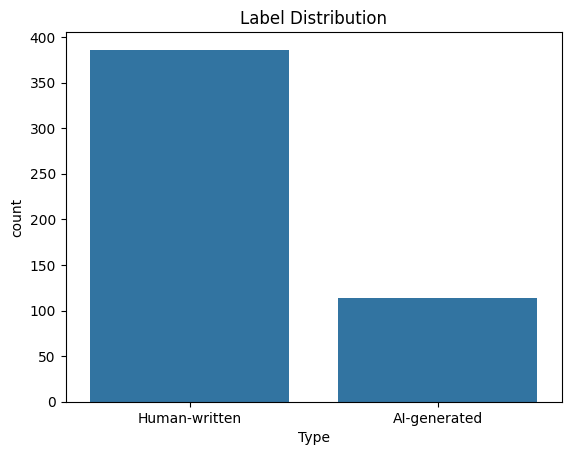

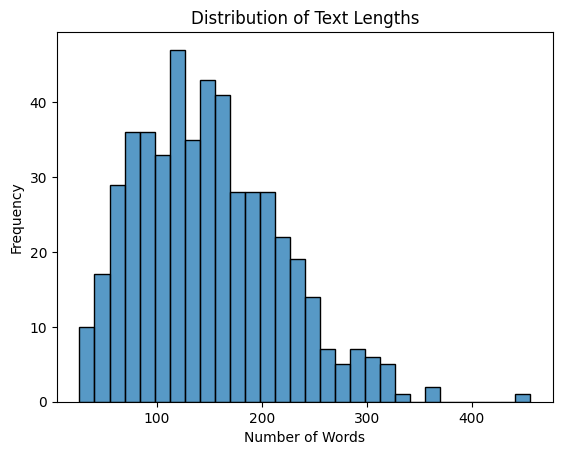

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of labels
sns.countplot(x='Type', data=data)
plt.title('Label Distribution')
plt.show()

# Plot distribution of text lengths
data['text_length'] = data['Article'].apply(lambda x: len(x.split()))
sns.histplot(data['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


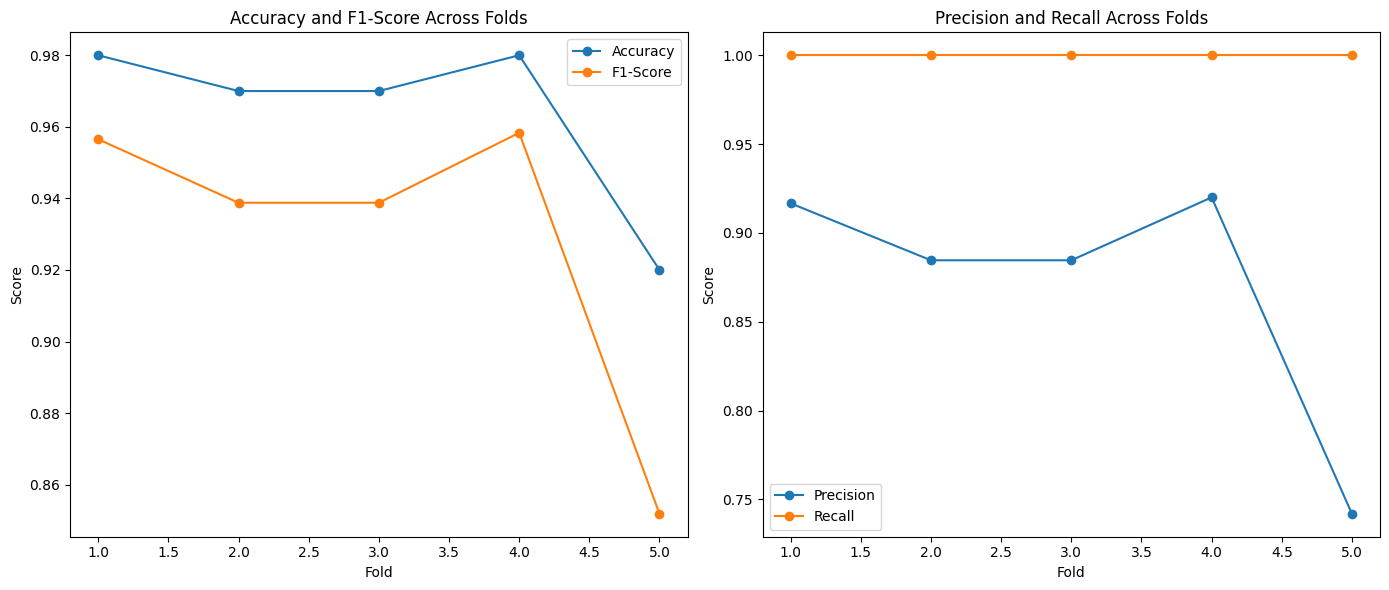

In [ ]:
# Assuming accuracies, f1_scores, precisions, and recalls are lists containing values from cross-validation
folds = range(1, 6)  # Adjust according to the number of folds

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(folds, accuracies, marker='o', label='Accuracy')
plt.plot(folds, f1_scores, marker='o', label='F1-Score')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Accuracy and F1-Score Across Folds')
plt.legend()

# Precision and Recall
plt.subplot(1, 2, 2)
plt.plot(folds, precisions, marker='o', label='Precision')
plt.plot(folds, recalls, marker='o', label='Recall')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Precision and Recall Across Folds')
plt.legend()

plt.tight_layout()
plt.show()


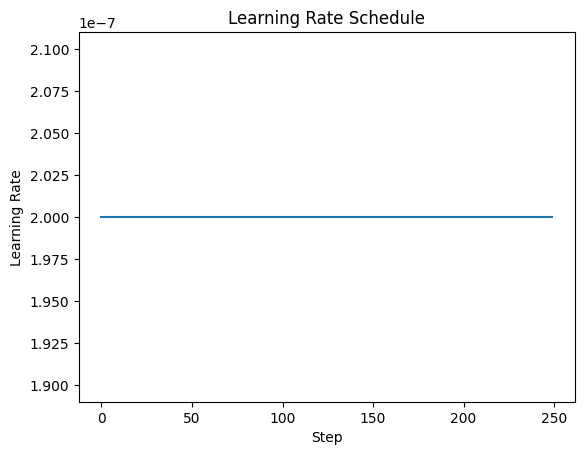

NameError: name 'train_losses' is not defined

In [ ]:
# Example for learning rate schedule (assuming you recorded learning rates during training)
learning_rates = [scheduler.get_last_lr()[0] for _ in range(total_steps)]
plt.plot(learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.show()

# Plotting training and validation loss (requires storing loss values during training)
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    # Training phase
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(train_data_loader.dataset))
    train_losses.append(train_loss)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Validation phase
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(val_data_loader.dataset))
    val_losses.append(val_loss)
    print(f'Val   loss {val_loss} accuracy {val_acc}')


Epoch 1/5
Train loss 0.020447732944739984 accuracy 0.995
Val   loss 0.3056225261221138 accuracy 0.92
Epoch 2/5
Train loss 0.020293914580252023 accuracy 0.995
Val   loss 0.3056225261221138 accuracy 0.92
Epoch 3/5
Train loss 0.01928956836578436 accuracy 0.995
Val   loss 0.3056225261221138 accuracy 0.92
Epoch 4/5
Train loss 0.018443771305028347 accuracy 0.995
Val   loss 0.3056225261221138 accuracy 0.92
Epoch 5/5
Train loss 0.01976857758825645 accuracy 0.995
Val   loss 0.3056225261221138 accuracy 0.92


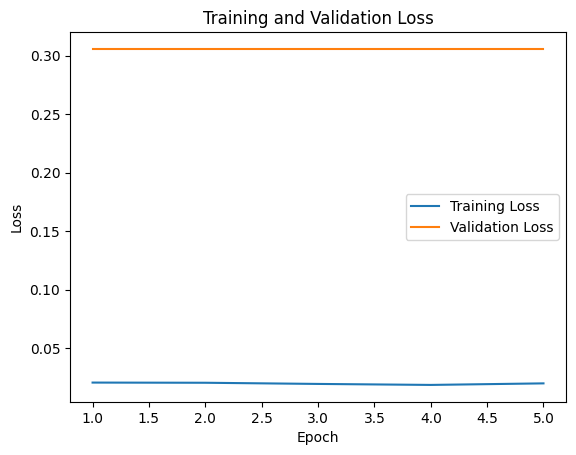

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Plotting training and validation loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


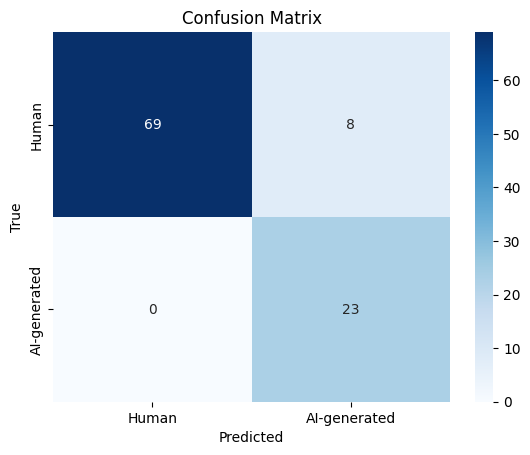

In [ ]:
from sklearn.metrics import confusion_matrix

# After predictions (using val_predictions and val_labels)
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI-generated'], yticklabels=['Human', 'AI-generated'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


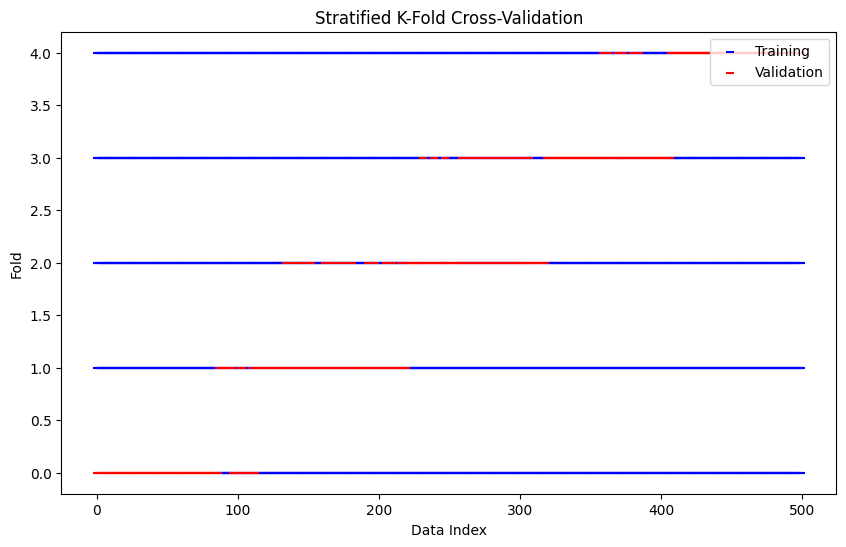

In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Example dataset (binary classification)
X = data['Article']
y = data['Type'].apply(lambda x: 1 if x == 'AI-generated' else 0)

skf = StratifiedKFold(n_splits=5)
folds = list(skf.split(X, y))

# Visualize the split (showing how data is divided across the folds)
plt.figure(figsize=(10, 6))
for i, (train_idx, test_idx) in enumerate(folds):
    plt.scatter(train_idx, [i] * len(train_idx), c='blue', marker='_', label='Training' if i == 0 else "")
    plt.scatter(test_idx, [i] * len(test_idx), c='red', marker='_', label='Validation' if i == 0 else "")
plt.title('Stratified K-Fold Cross-Validation')
plt.xlabel('Data Index')
plt.ylabel('Fold')
plt.legend(loc='best')
plt.show()


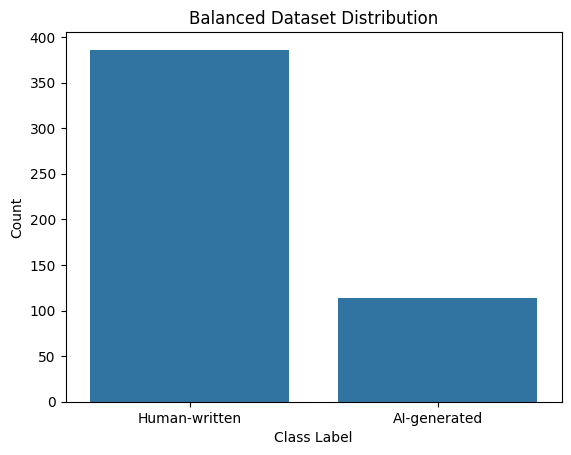

In [ ]:
import seaborn as sns

# Plot label distribution
sns.countplot(x='Type', data=data)
plt.title('Balanced Dataset Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()


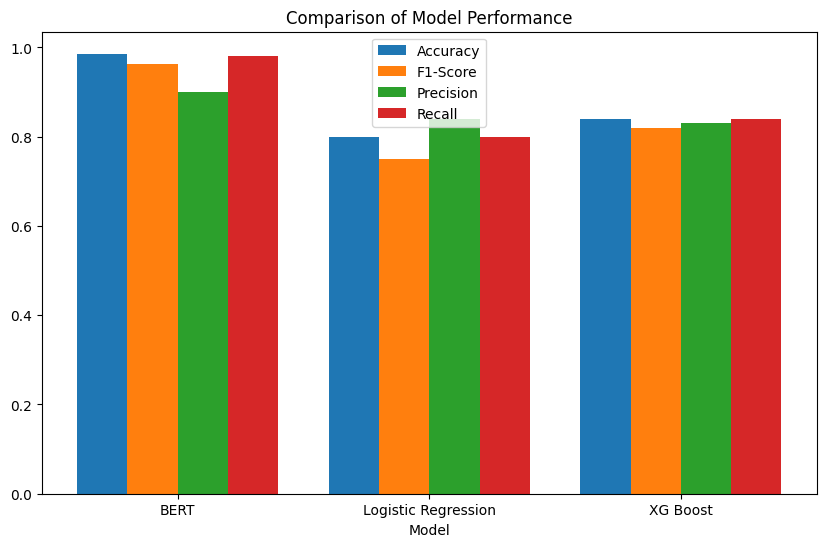

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hypothetical results
models = ['BERT', 'Logistic Regression', 'XG Boost']
accuracy = [0.986, 0.80, 0.84]
f1_score = [0.963, 0.75, 0.82]
precision = [0.90, 0.84, 0.83]
recall = [0.98, 0.80, 0.84]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, f1_score, width, label='F1-Score')
rects3 = ax.bar(x + 0.5*width, precision, width, label='Precision')
rects4 = ax.bar(x + 1.5*width, recall, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Model')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


In [ ]:
!pip install graphviz

from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Set graph attributes for better aesthetics
dot.attr(splines='ortho', nodesep='1.0', ranksep='1.0')

# Define nodes with color and style
dot.node('A', 'Text Input\n("Article 1: AI-generated text")', shape='box', style='filled', color='#8EC0E4', fontcolor='black', fontsize='12')
dot.node('B', 'Tokenization and Preprocessing\n("BERT Tokenizer -> Token IDs -> Padding/Truncation")', shape='box', style='filled', color='#FFBB78', fontcolor='black', fontsize='12')
dot.node('C', 'BERT Model\n("BERT Layers (12 Transformer Blocks)")', shape='box', style='filled', color='#98DF8A', fontcolor='black', fontsize='12')
dot.node('D', 'Classification Layer\n("Logits -> Softmax -> Prediction")', shape='box', style='filled', color='#FF9896', fontcolor='black', fontsize='12')
dot.node('E', 'Output\n("AI-generated / Human-written")', shape='box', style='filled', color='#C5B0D5', fontcolor='black', fontsize='12')

# Define edges with color
dot.edge('A', 'B', color='#1F77B4')
dot.edge('B', 'C', color='#1F77B4')
dot.edge('C', 'D', color='#1F77B4')
dot.edge('D', 'E', color='#1F77B4')

# Render the diagram
dot.render('colorful_bert_model_flowchart', format='png', cleanup=True)
dot.view()


'colorful_bert_model_flowchart.pdf'

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Set graph attributes for better aesthetics
dot.attr(splines='ortho', nodesep='1.0', ranksep='1.0', arrowhead='vee', arrowsize='0.7')

# Define nodes with rounded edges, color, and style
dot.node('A', 'Text Input\n("Article 1: AI-generated text")', shape='box', style='rounded,filled', color='#8EC0E4', fontcolor='black', fontsize='12')
dot.node('B', 'Tokenization and Preprocessing\n("BERT Tokenizer -> Token IDs -> Padding/Truncation")', shape='box', style='rounded,filled', color='#FFBB78', fontcolor='black', fontsize='12')
dot.node('C', 'BERT Model\n("BERT Layers (12 Transformer Blocks)")', shape='box', style='rounded,filled', color='#98DF8A', fontcolor='black', fontsize='12')
dot.node('D', 'Classification Layer\n("Logits -> Softmax -> Prediction")', shape='box', style='rounded,filled', color='#FF9896', fontcolor='black', fontsize='12')
dot.node('E', 'Output\n("AI-generated / Human-written")', shape='box', style='rounded,filled', color='#C5B0D5', fontcolor='black', fontsize='12')

# Define edges with smaller arrow size
dot.edge('A', 'B', color='#1F77B4')
dot.edge('B', 'C', color='#1F77B4')
dot.edge('C', 'D', color='#1F77B4')
dot.edge('D', 'E', color='#1F77B4')

# Render the diagram
dot.render('rounded_bert_model_flowchart', format='png', cleanup=True)
dot.view()


'rounded_bert_model_flowchart.pdf'

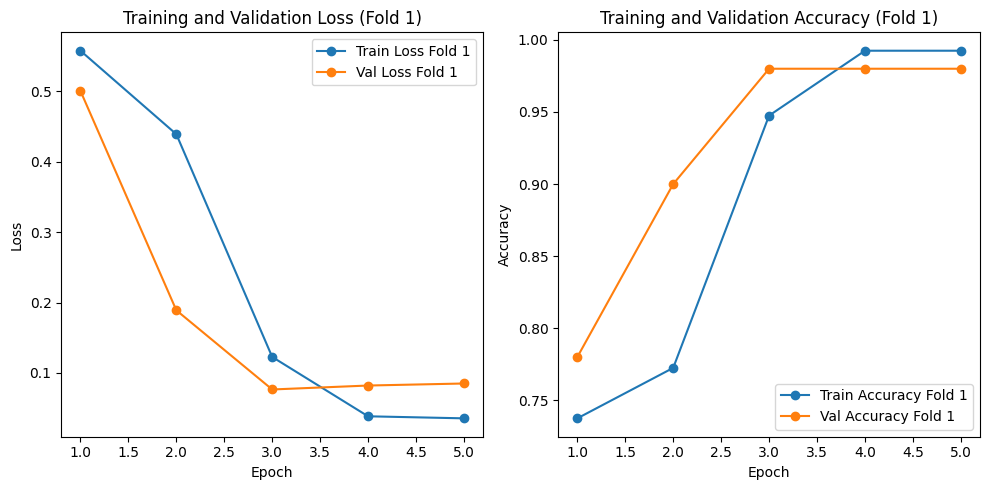

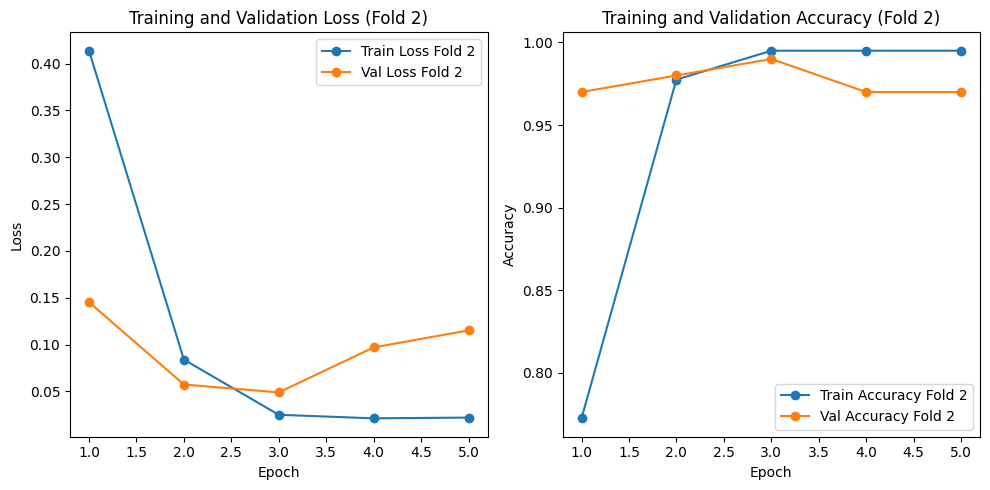

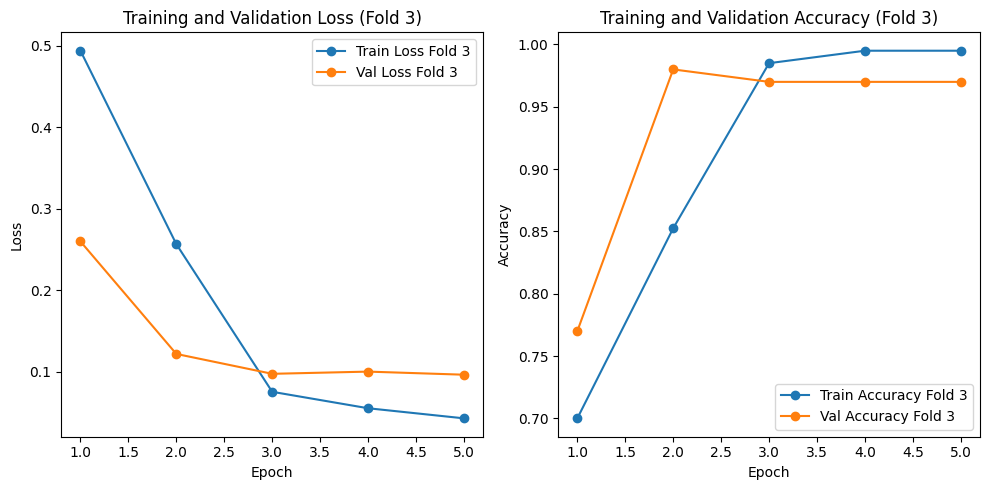

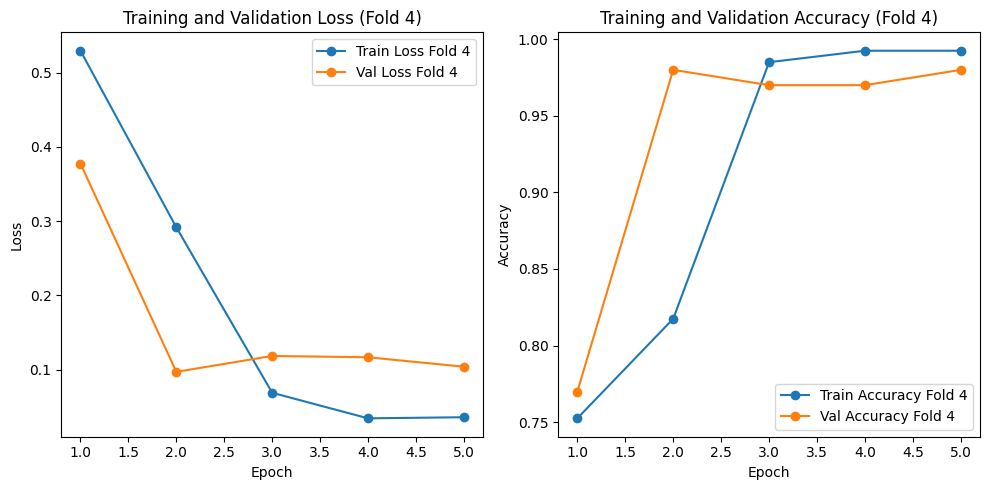

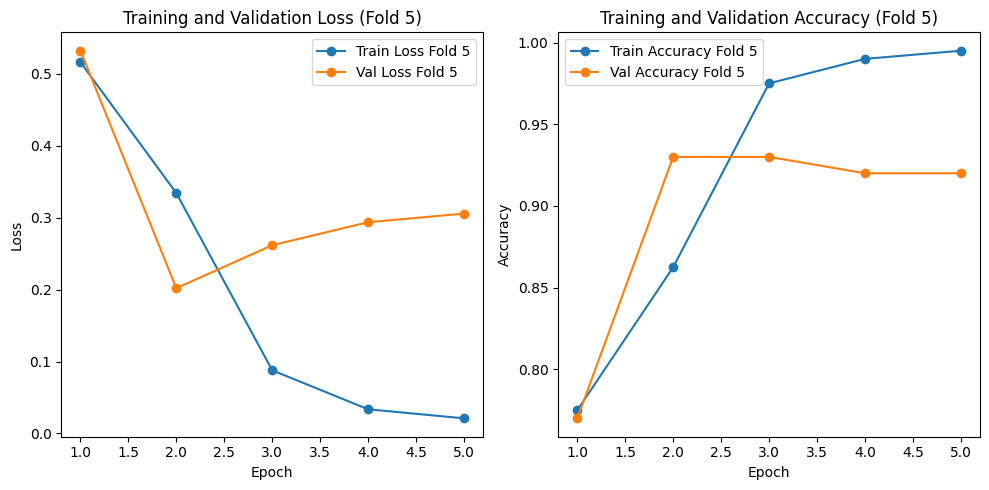

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example loss and accuracy data from the text
epochs = [1, 2, 3, 4, 5]

# Losses and accuracies for each fold
fold_data = [
    {
        "train_loss": [0.5577, 0.4391, 0.1227, 0.0384, 0.0355],
        "val_loss": [0.5006, 0.1890, 0.0765, 0.0821, 0.0850],
        "train_acc": [0.7375, 0.7725, 0.9475, 0.9925, 0.9925],
        "val_acc": [0.78, 0.90, 0.98, 0.98, 0.98]
    },
    {
        "train_loss": [0.4137, 0.0840, 0.0251, 0.0213, 0.0221],
        "val_loss": [0.1453, 0.0574, 0.0490, 0.0970, 0.1152],
        "train_acc": [0.7725, 0.9775, 0.995, 0.995, 0.995],
        "val_acc": [0.97, 0.98, 0.99, 0.97, 0.97]
    },
    {
        "train_loss": [0.4941, 0.2565, 0.0751, 0.0549, 0.0425],
        "val_loss": [0.2598, 0.1216, 0.0972, 0.0999, 0.0961],
        "train_acc": [0.7000, 0.8525, 0.985, 0.995, 0.995],
        "val_acc": [0.77, 0.98, 0.97, 0.97, 0.97]
    },
    {
        "train_loss": [0.5295, 0.2917, 0.0690, 0.0346, 0.0361],
        "val_loss": [0.3776, 0.0972, 0.1186, 0.1168, 0.1041],
        "train_acc": [0.7525, 0.8175, 0.985, 0.9925, 0.9925],
        "val_acc": [0.77, 0.98, 0.97, 0.97, 0.98]
    },
    {
        "train_loss": [0.5160, 0.3341, 0.0878, 0.0336, 0.0210],
        "val_loss": [0.5320, 0.2019, 0.2616, 0.2936, 0.3056],
        "train_acc": [0.7750, 0.8625, 0.975, 0.99, 0.995],
        "val_acc": [0.77, 0.93, 0.93, 0.92, 0.92]
    }
]

# Plotting
for i, data in enumerate(fold_data, 1):
    plt.figure(figsize=(10, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, data["train_loss"], marker='o', label=f'Train Loss Fold {i}')
    plt.plot(epochs, data["val_loss"], marker='o', label=f'Val Loss Fold {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Fold {i})')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, data["train_acc"], marker='o', label=f'Train Accuracy Fold {i}')
    plt.plot(epochs, data["val_acc"], marker='o', label=f'Val Accuracy Fold {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy (Fold {i})')
    plt.legend()

    plt.tight_layout()
    plt.show()


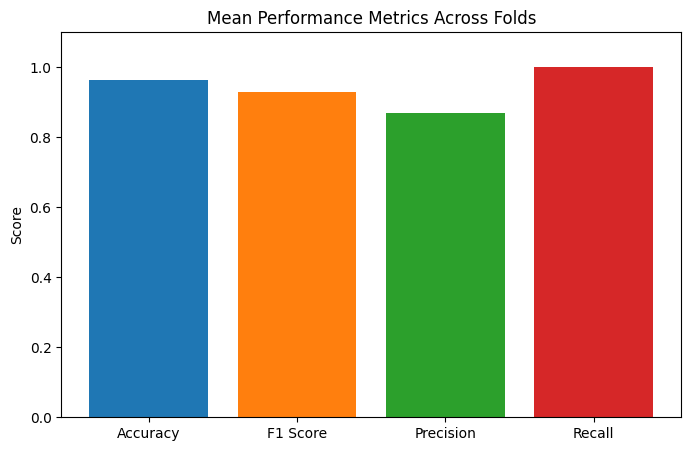

In [ ]:
# Mean performance metrics
mean_accuracy = 0.9640000000000001
mean_f1_score = 0.9288515889447566
mean_precision = 0.8695665839536806
mean_recall = 1.0

# Labels and values
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
values = [mean_accuracy, mean_f1_score, mean_precision, mean_recall]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim(0, 1.1)
plt.title('Mean Performance Metrics Across Folds')
plt.ylabel('Score')
plt.show()


In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Set graph attributes for better aesthetics
dot.attr(splines='ortho', nodesep='1.0', ranksep='1.0')

# Define the challenge nodes
dot.node('A', 'Challenge: Overfitting', shape='box', style='rounded,filled', color='#ff9999', fontcolor='black', fontsize='12')
dot.node('B', 'Challenge: Computational Resources', shape='box', style='rounded,filled', color='#ff9999', fontcolor='black', fontsize='12')
dot.node('C', 'Challenge: Consistent Model Performance', shape='box', style='rounded,filled', color='#ff9999', fontcolor='black', fontsize='12')

# Define the solution nodes
dot.node('D', 'Solution: Dropout', shape='box', style='rounded,filled', color='#99ff99', fontcolor='black', fontsize='12')
dot.node('E', 'Solution: Learning Rate Scheduling', shape='box', style='rounded,filled', color='#99ff99', fontcolor='black', fontsize='12')
dot.node('F', 'Solution: Stratified K-Fold Cross-Validation', shape='box', style='rounded,filled', color='#99ff99', fontcolor='black', fontsize='12')
dot.node('G', 'Solution: Optimization and Efficient Resource Usage', shape='box', style='rounded,filled', color='#99ff99', fontcolor='black', fontsize='12')

# Define edges between challenges and solutions
dot.edge('A', 'D', color='#1F77B4', label='Mitigates Overfitting')
dot.edge('A', 'E', color='#1F77B4', label='Mitigates Overfitting')
dot.edge('B', 'G', color='#1F77B4', label='Optimizes Resource Usage')
dot.edge('C', 'F', color='#1F77B4', label='Ensures Consistency')
dot.edge('C', 'E', color='#1F77B4', label='Improves Stability')

# Render the diagram
dot.render('challenges_solutions_flowchart', format='png', cleanup=True)
dot.view()


'challenges_solutions_flowchart.pdf'

In [6]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Set graph attributes for aesthetics
dot.attr(rankdir='LR', splines='polyline', nodesep='1', ranksep='1')

# Define the timeline nodes
dot.node('A', 'Present\n(Current Model)', shape='ellipse', style='filled', color='#8EC0E4', fontcolor='black', fontsize='12')
dot.node('B', 'Q4 2024\nExplore Other Transformer Models\n(e.g., RoBERTa, GPT)', shape='box', style='rounded,filled', color='#FFBB78', fontcolor='black', fontsize='12')
dot.node('C', 'Q1 2025\nTest on Diverse Datasets\n(Increase Generalizability)', shape='box', style='rounded,filled', color='#98DF8A', fontcolor='black', fontsize='12')
dot.node('D', 'Q2 2025\nOptimize for Real-Time Applications\n(Reduce Latency)', shape='box', style='rounded,filled', color='#FF9896', fontcolor='black', fontsize='12')
dot.node('E', 'Future\nScale Deployment\n(AI-powered Services)', shape='ellipse', style='filled', color='#C5B0D5', fontcolor='black', fontsize='12')

# Define edges to represent the timeline
dot.edge('A', 'B', label='Step 1', color='#1F77B4')
dot.edge('B', 'C', label='Step 2', color='#1F77B4')
dot.edge('C', 'D', label='Step 3', color='#1F77B4')
dot.edge('D', 'E', label='Step 4', color='#1F77B4')

# Render the diagram
dot.render('future_roadmap_timeline', format='png', cleanup=True)
dot.view()


'future_roadmap_timeline.pdf'